In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
url = 'https://raw.githubusercontent.com/jakevdp/bicycle-data/main'
!curl -O {url}/FremontBridge.csv
!curl -O {url}/SeattleWeather.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4585k  100 4585k    0     0  13.8M      0 --:--:-- --:--:-- --:--:-- 13.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  534k  100  534k    0     0  2268k      0 --:--:-- --:--:-- --:--:-- 2274k


In [8]:
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/SeattleWeather.csv', index_col='DATE', parse_dates=True)

/tmp/ipykernel_2775240/3601648649.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


For simplicity, let's look at data prior to 2020 in order to avoid the effects of the COVID-19 pandemic, which significantly affected commuting patterns in Seattle

In [11]:
counts = counts[counts.index < "2020-01-01"]
weather = weather[weather.index < "2020-01-01"]

In [12]:
counts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127008 entries, 2019-11-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Fremont Bridge Total          126988 non-null  float64
 1   Fremont Bridge East Sidewalk  126988 non-null  float64
 2   Fremont Bridge West Sidewalk  126988 non-null  float64
dtypes: float64(3)
memory usage: 3.9 MB


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2012-01-01 to 2019-12-31
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  2922 non-null   object 
 1   NAME     2922 non-null   object 
 2   AWND     2922 non-null   float64
 3   FMTM     31 non-null     float64
 4   PGTM     83 non-null     float64
 5   PRCP     2922 non-null   float64
 6   SNOW     2922 non-null   float64
 7   SNWD     2922 non-null   float64
 8   TAVG     2466 non-null   float64
 9   TMAX     2922 non-null   int64  
 10  TMIN     2922 non-null   int64  
 11  WDF2     2922 non-null   int64  
 12  WDF5     2897 non-null   float64
 13  WSF2     2922 non-null   float64
 14  WSF5     2897 non-null   float64
 15  WT01     1254 non-null   float64
 16  WT02     150 non-null    float64
 17  WT03     27 non-null     float64
 18  WT04     8 non-null      float64
 19  WT05     3 non-null      float64
 20  WT08     141 non-null    float64
 

In [36]:
daily = counts.resample('D').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]
daily.head()

,Total
Date,
2012-10-03,14084.0
2012-10-04,13900.0
2012-10-05,12592.0
2012-10-06,8024.0
2012-10-07,8568.0


In order to analyze by day of week, create binary columns for each day.

In [37]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

### Holidays

In [38]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily.holiday.fillna(0, inplace=True)

### Daylight Hours

(8.0, 17.0)

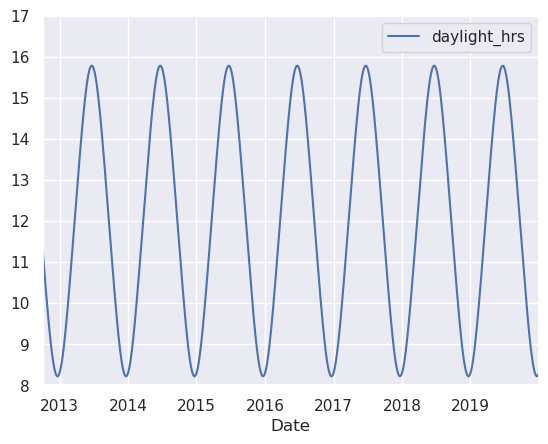

In [39]:
from datetime import datetime
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.to_datetime(datetime(2000, 12, 21))).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis)
        * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

### Add weather data (temp and preciptation)

In [25]:
weather = pd.read_csv('data/SeattleWeather.csv', index_col='DATE', parse_dates=True)

In [26]:
weather['Temp (F)'] = 0.5 * (weather.TMIN + weather.TMAX)
weather['Rainfall (in)'] = weather.PRCP
weather['dry day'] = (weather.PRCP == 0).astype(int)

In [40]:
daily = daily.join(weather[['Rainfall (in)', 'Temp (F)', 'dry day']], rsuffix='other')

In [41]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day
Date,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,60.5,1


In [43]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [44]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,60.5,1,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data. 

We will set `fit_intercept=False`, because the daily flags essentially operate as their own day-specific intercepts:

In [48]:
from sklearn.linear_model import LinearRegression
daily.dropna(axis=0, how='any', inplace=True)
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
                'holiday', 'daylight_hrs', 'Rainfall (in)',
                'dry day', 'Temp (F)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

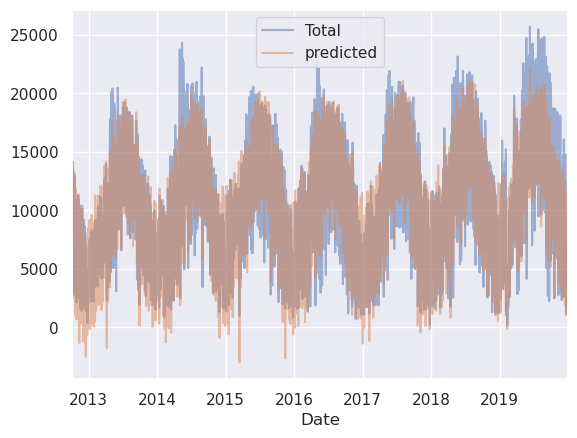

In [49]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [50]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -3309.953439
Tue              -2860.625060
Wed              -2962.889892
Thu              -3480.656444
Fri              -4836.064503
Sat             -10436.802843
Sun             -10795.195718
holiday          -5006.995232
daylight_hrs       409.146368
Rainfall (in)    -2789.860745
dry day           2111.069565
Temp (F)           179.026296
annual             324.437749
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [51]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
             for i in range(1000)], 0)

In [52]:
print(pd.DataFrame({
    'effect': params.round(0),
    'uncertainty': err.round(0)
}))

                effect  uncertainty
Mon            -3310.0        265.0
Tue            -2861.0        274.0
Wed            -2963.0        268.0
Thu            -3481.0        268.0
Fri            -4836.0        261.0
Sat           -10437.0        259.0
Sun           -10795.0        267.0
holiday        -5007.0        401.0
daylight_hrs     409.0         26.0
Rainfall (in)  -2790.0        186.0
dry day         2111.0        101.0
Temp (F)         179.0          7.0
annual           324.0         22.0


The effect column here, roughly speaking, shows how the number of riders is affected by a change of the feature in question. For example, there is a clear divide when it comes to the day of the week: there are thousands fewer riders on weekends than on weekdays. We also see that for each additional hour of daylight, 409 ± 26 more people choose to ride; a temperature increase of one degree Fahrenheit encourages 179 ± 7 people to grab their bicycle; a dry day means an average of 2,111 ± 101 more riders, and every inch of rainfall leads 2,790 ± 186 riders to choose another mode of transport. Once all these effects are accounted for, we see a modest increase of 324 ± 22 new daily riders each year.